### Import dependencies

In [1]:
import torch
from tqdm import tqdm
import pandas as pd
from IPython.display import Image

tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

### Configuration

In [2]:
config = PPOConfig(model_name="maxfil333/gpt2_imdb_generator_v2",
                   learning_rate=1.41e-5,
                   log_with="wandb",
                   tracker_project_name='trl_v2',
                   batch_size=32)

import wandb

wandb.init()

## Load data and models

In [3]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):

    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token

    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds = ds.remove_columns(['review'])
    ds.set_format(type="torch")
    return ds

In [4]:
dataset = build_dataset(config)

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### one batch of ds

In [5]:
for batch in dataset:
    print(batch)
    break

{'label': tensor(0), 'input_ids': tensor([   40, 26399,   314,  3001,   327, 47269, 20958]), 'query': 'I rented I AM CURIOUS'}


### Load pre-trained GPT2 language models

In [6]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
tokenizer = AutoTokenizer.from_pretrained(config.model_name)

tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Initialize PPOTrainer

In [7]:
ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)

wandb: Currently logged in as: maxfil333. Use `wandb login --relogin` to force relogin


In [8]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug

In [9]:
for batch in ppo_trainer.dataloader:
    print(batch)
    break

{'label': [tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0')], 'input_ids': [tensor([19197,   645,  3241,   284], device='cuda:0'), tensor([1212, 3807,  37

### Load BERT classifier

In [10]:
sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 8}

In [11]:
sentiment_pipe = pipeline("sentiment-analysis", model="maxfil333/bert_imdb_classifier", device=device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [12]:
text = "this movie was really bad!!"
sentiment_pipe(text, **sent_kwargs)

D:\my_projects\gpt2_sentiment\venv\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'neg', 'score': 2.4248106479644775},
  {'label': 'pos', 'score': -2.7729527950286865}]]

In [13]:
text = "this movie was really good!!"
sentiment_pipe(text, **sent_kwargs)

[[{'label': 'neg', 'score': -2.663987636566162},
  {'label': 'pos', 'score': 2.5000836849212646}]]

## Optimize model

### Training loop

In [ ]:
output_min_length = 12
output_max_length = 24
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

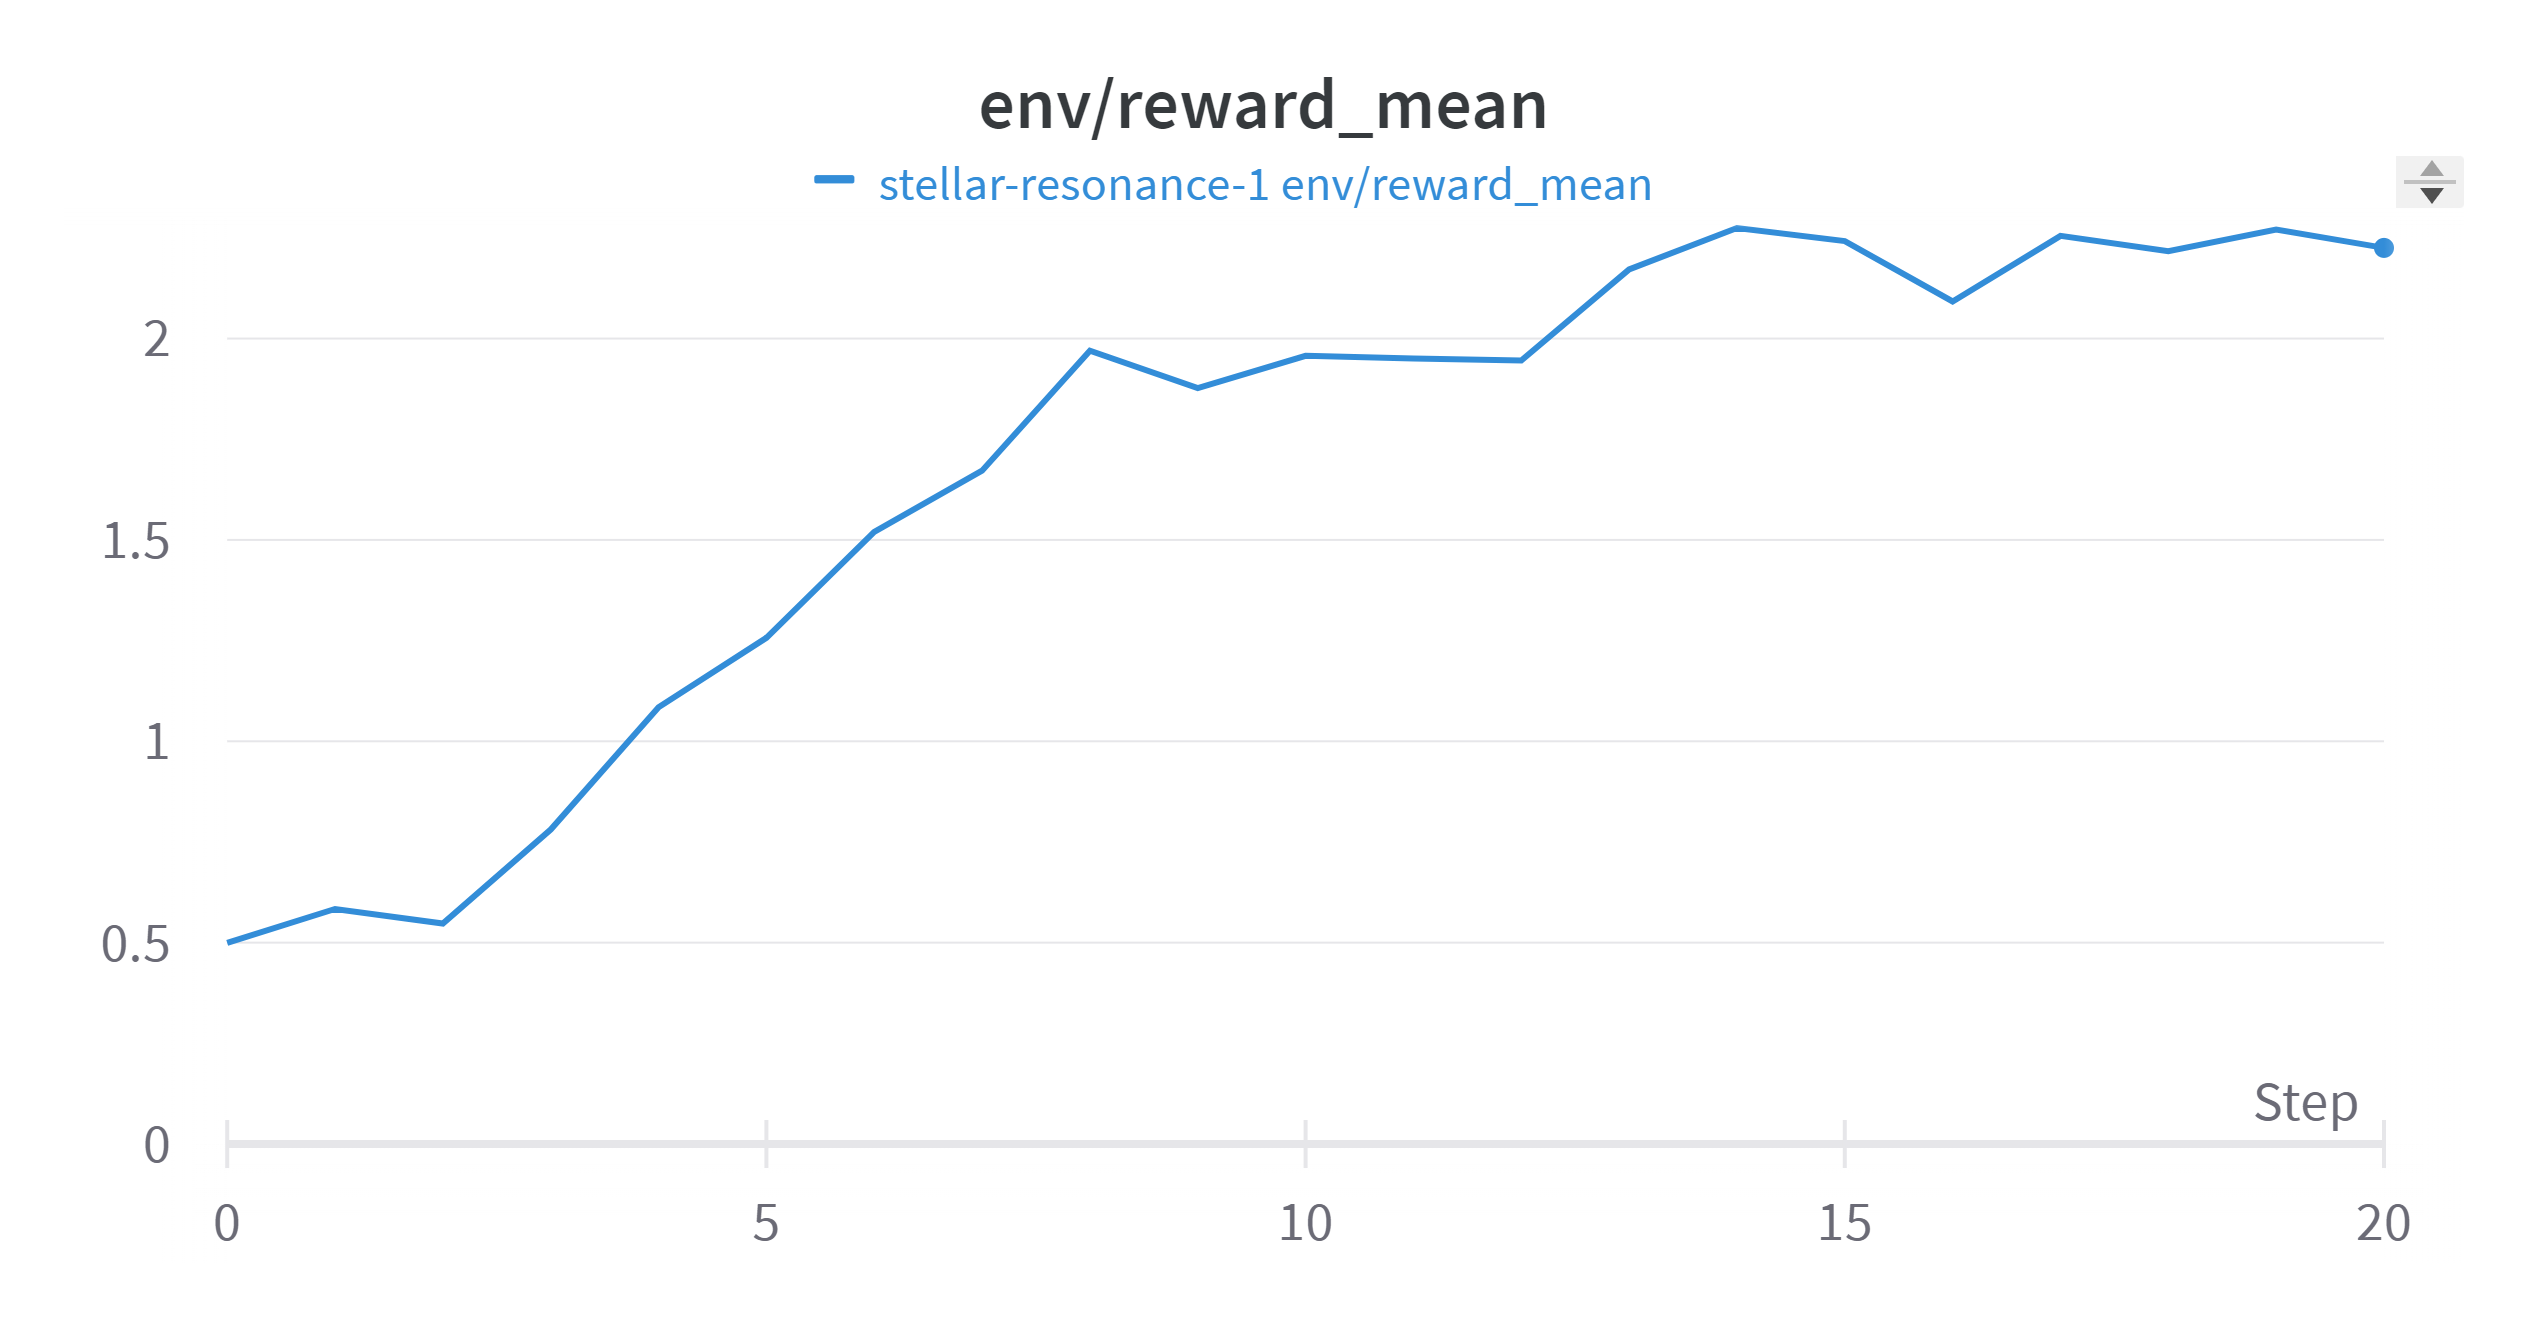

In [15]:
Image(filename='reports/env_reward.png')

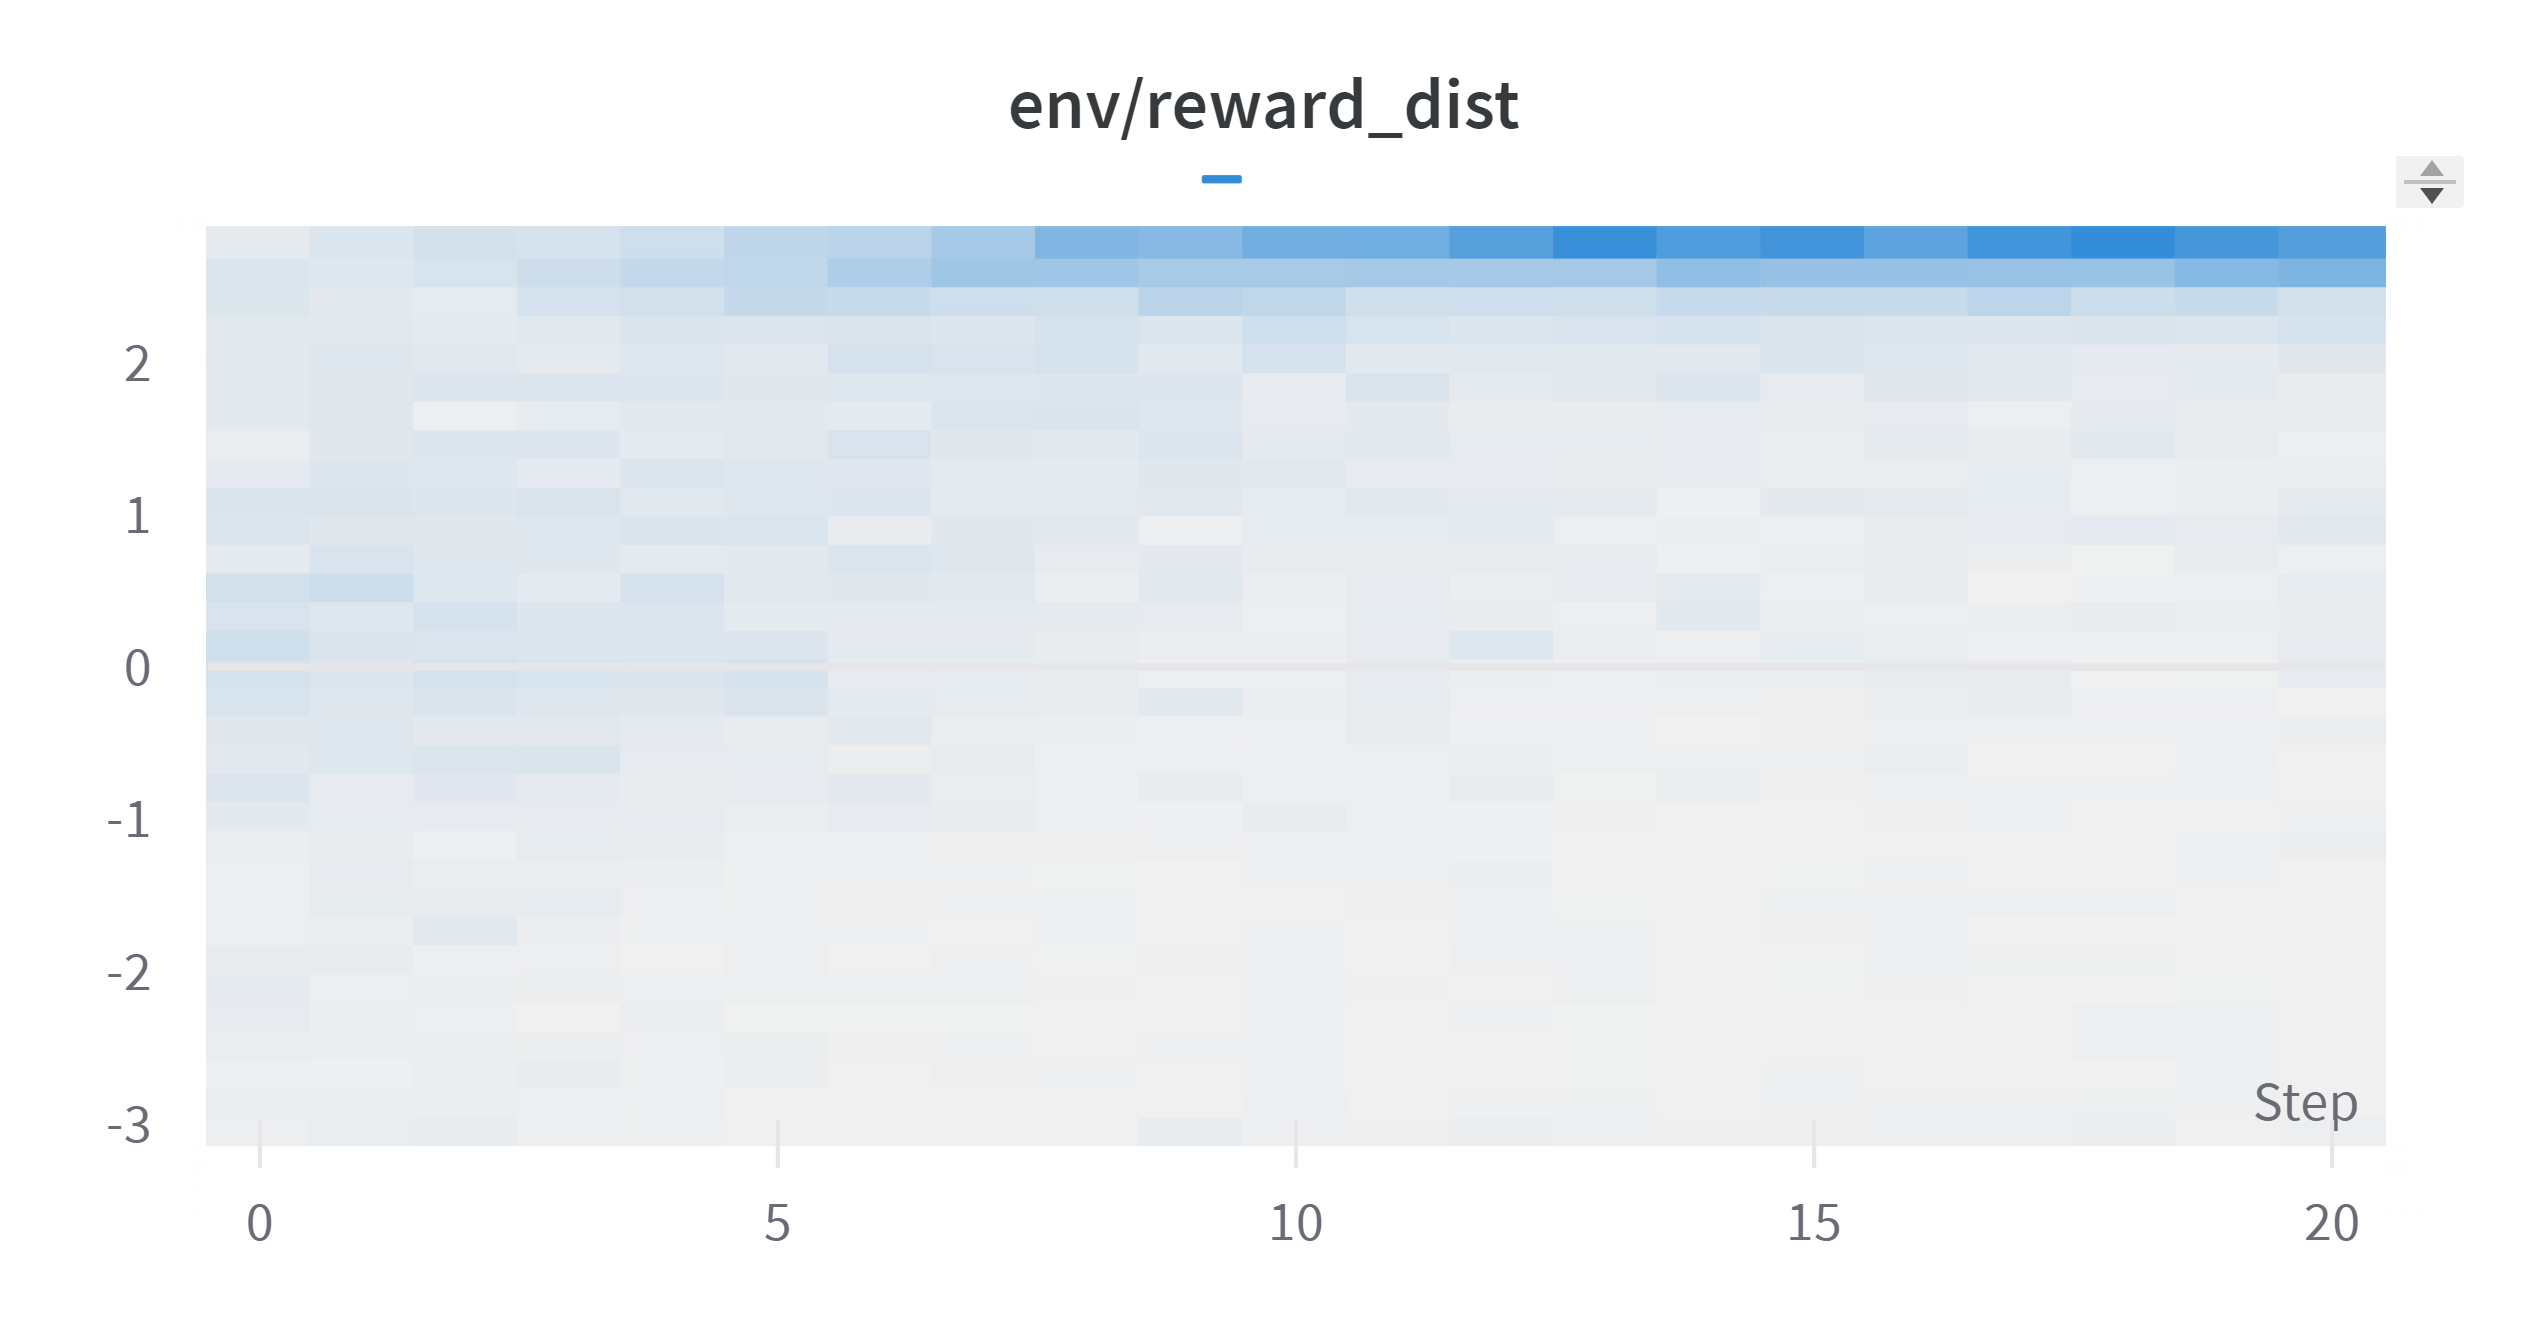

In [16]:
Image(filename='reports/env_reward_dist.png')

## Model inspection

In [17]:
gen_kwargs = {"min_length": -1, 
              "top_k": 0.0, 
              "top_p": 1.0, 
              "do_sample": True, 
              "pad_token_id": tokenizer.eos_token_id}

In [18]:
#### get a batch from the dataset
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

D:\my_projects\gpt2_sentiment\venv\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
D:\my_projects\gpt2_sentiment\venv\Lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,query,response (before),response (after),rewards (before),rewards (after)
0,"""The Notorious","B.I.G."" trailer is probably the most memorabl...",is a fascinating Australian film featuring ma...,1.953604,2.923629
1,A 14 year,old boy is trapped by a spy for The Musical's...,old boy is a wonderful article from his favor...,-0.182624,2.671024
2,This is one of those rare,"masterpieces, which are standard fare for Pau...",horror films whose main cast is all demon aud...,2.753513,2.655973
3,The Forest isn,"'t perfect, some of the plots are immediate an...","'t exactly a great film, but it is fine. It has",-0.824145,2.376343
4,Helena Bonham Carter,", Malia Louis and Bruno Celia star in the film...",is an absolutely wonderful story bracelet. Th...,1.777267,2.821801
5,I had been looking forward,to this film for a long time and I wasn't dis...,to this film. It is also one of the few live ...,0.824743,1.477400
6,"Nicely done, and along",with the premise of this cheerful movie I rea...,with this superb movie. The all-world chapter...,2.231441,2.857586
7,"Ashley Judd, in","a bit of a sparring match with John Travolta,","this terrific comedy, is beautiful. Her actin...",0.774042,2.866408
8,I was worried that my,other daughters were acting reviled entirely ...,reaction would be much different than I alrea...,0.031110,2.863181
9,Despite the feelings of most,members of my club (those who enjoy Jaunah Ba...,"television writers, one is still a highly pri...",1.009740,2.837180


Looking at the reward mean/median of the generated sequences we observe a significant difference.

In [19]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)    0.915920
rewards (after)     2.434158
dtype: float64


median:


rewards (before)    0.799392
rewards (after)     2.809464
dtype: float64

## Save model

In [20]:
model.save_pretrained("./models/trl_model_v2", push_to_hub=False)

In [21]:
model.push_to_hub("gpt2_pos_imdb_generator_v2")

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/maxfil333/gpt2_pos_imdb_generator_v2/commit/f4659637158f8fa0116dd1eb24e53b639da04ee2', commit_message='Upload model', commit_description='', oid='f4659637158f8fa0116dd1eb24e53b639da04ee2', pr_url=None, pr_revision=None, pr_num=None)

In [22]:
tokenizer.push_to_hub("gpt2_pos_imdb_generator_v2")

CommitInfo(commit_url='https://huggingface.co/maxfil333/gpt2_pos_imdb_generator_v2/commit/ab702c4ee3b6b7e7a885e6816249867dea8a41cb', commit_message='Upload tokenizer', commit_description='', oid='ab702c4ee3b6b7e7a885e6816249867dea8a41cb', pr_url=None, pr_revision=None, pr_num=None)